In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer ,CplexOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date, timedelta, datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore", SymPyDeprecationWarning)
import mplfinance as mpl
warnings.filterwarnings('ignore')

In [2]:
#Client API configuration

from dotenv import load_dotenv
load_dotenv()
import os
API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

In [3]:
from binance.client import Client

In [4]:
client = Client(API_KEY,API_SECRET)

In [5]:
info = pd.DataFrame(client.get_all_tickers())

In [6]:
##Get all the cryptocurrencies with USDT conversion.

assets = ['BNBUSDT','BTCUSDT','ETHUSDT','SOLUSDT','ADAUSDT','XRPUSDT','DOTUSDT','DOGEUSDT']
#assets = [symbol for symbol in info['symbol'] if 'USDT' in symbol]


#start="2020.10.23"
days = 365
#end = (datetime.today()-timedelta(days=1)).strftime("%Y.%m.%d")
start = (datetime.today()-timedelta(days=days)).strftime("%Y.%m.%d")
end = (datetime.today()).strftime("%Y.%m.%d")
timeframe="1d"

In [7]:
#Filter only CC with 366 days

df = pd.DataFrame()
for asset in assets:
    df_aux= pd.DataFrame(client.get_historical_klines(asset, timeframe,start,end))
    if len(df_aux) == (days+1):
        df_aux=df_aux.iloc[:,:6]
        df_aux.columns=["Date","Open","High","Low","Close","Volume"]
        df_aux.insert(1, "asset", asset, allow_duplicates=False)
        df = df.append(df_aux)

df['Date']=pd.to_datetime(df['Date'],unit="ms")
df.set_index('Date',inplace = True)
df.iloc[:,1:6]=df.iloc[:,1:6].astype("float")
assets = df['asset'].unique()

In [8]:
assets

array(['BNBUSDT', 'BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'ADAUSDT', 'XRPUSDT',
       'DOTUSDT', 'DOGEUSDT'], dtype=object)

In [9]:
print(f"Amount of CC {len(assets)}.")

Amount of CC 8.


In [ ]:
#Plot trends

#for asset in assets:    
#    #mpl.plot(df[df['asset'] == asset], type='candle', volume=True, mav=7,title=asset)
#    mpl.plot(df[df['asset'] == asset], type='line', volume=True,title=asset)

In [10]:
#Get Mu(avg. of returns) and Sigma(covariance matrix)

mu = {}
retornos = []
retornos_x = []

for asset in assets:
    lista = np.array(df[df['asset'] == asset]['Close'])
    retornos = (lista[1:]/lista[:-1])-1
    mu[asset] = np.average(retornos)
    retornos_x.append(retornos)
    #retornos_x = retornos_x.append(retornos)
#x = np.vstack([retornos_x[0],retornos_x[1],retornos_x[2],retornos_x[3],retornos_x[4],retornos_x[5],retornos_x[6],retornos_x[7]])
x = np.vstack(retornos_x)
sigma = np.cov(x)

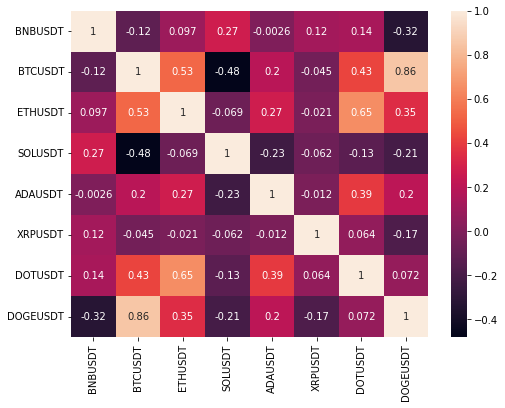

In [11]:
corr_df = pd.DataFrame(sigma).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True,xticklabels=assets, yticklabels=assets)
plt.show()

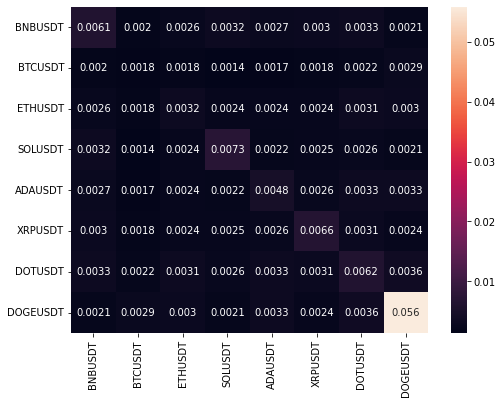

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(sigma, annot=True,xticklabels=assets, yticklabels=assets)
plt.show()

In [13]:
#Build QUBO function to optimize

num_assets = len(assets)     
q = 0.1                  
budget = round(len(assets)*0.2)       
seed = 19900330  

#portfolio = PortfolioOptimization([item for item in mu.values()],sigma,q,budget)
portfolio = PortfolioOptimization(expected_returns=[item for item in mu.values()], covariances=sigma, risk_factor=q, budget=budget,bounds=[[0,2]]*len(assets))
qp = portfolio.to_quadratic_program()

##############################
#print(qp)

In [35]:
%%time

###Classical Optimizer CPLEX###

#exact_mes = NumPyMinimumEigensolver()
#exact_eigensolver = MinimumEigenOptimizer(exact_mes)
#result = exact_eigensolver.solve(qp)

#print(result)
algorithm_globals.random_seed = 1990
cplex_optimizer = CplexOptimizer()
cplex_result = cplex_optimizer.solve(qp)

print(cplex_result)

optimal function value: -0.0325264324100574
optimal value: [0. 0. 0. 1. 0. 0. 0. 1.]
status: SUCCESS
CPU times: user 16.6 ms, sys: 31 ms, total: 47.6 ms
Wall time: 54.9 ms


In [48]:
%%time

###VQE###

optimizer = SLSQP(maxiter = 900000000)  
algorithm_globals.random_seed = 1990
backend = Aer.get_backend('qasm_simulator')

vqe = VQE(optimizer=optimizer, quantum_instance=backend)

vqe_meo = MinimumEigenOptimizer(vqe)
result = vqe_meo.solve(qp)

print(result)  

optimal function value: -0.02384977818173219
optimal value: [0. 0. 0. 0. 1. 0. 0. 1.]
status: SUCCESS
CPU times: user 2min 19s, sys: 1min 1s, total: 3min 21s
Wall time: 1min 47s


In [46]:
%%time

##QAOA###

algorithm_globals.massive=True
optimizer = COBYLA(maxiter = 50000000)  
algorithm_globals.random_seed = 1990
backend = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=backend, seed_simulator=1234, seed_transpiler=1234)
qaoa = QAOA(optimizer=optimizer,quantum_instance=backend)

qaoa_meo = MinimumEigenOptimizer(qaoa)

result = qaoa_meo.solve(qp)

print(result) 

optimal function value: -0.022169890084180407
optimal value: [0. 0. 0. 1. 0. 0. 1. 0.]
status: SUCCESS
CPU times: user 1min, sys: 26.2 s, total: 1min 26s
Wall time: 51.5 s
